足球最早源于中国古代的“蹴鞠”游戏，现代足球的起源地则是在英国，早在1872年，世界上第一场国家队之间正式的足球比赛就在苏格兰与英格兰之间展开。随着足球在全世界兴起，无数不同种族，不同肤色的人们疯狂的迷恋上这项竞技运动，足球也成为了世界第一大运动。

而世界杯足球赛则是全世界最引人注目的体育盛会之一，同奥运会、“F1”并称世界三大体育赛事。1930年，第一届世界杯足球赛在乌拉圭举办，最终东道主乌拉圭队在决赛中击败阿根廷，首次问鼎。此后，除了受第二次世界大战的影响停办两届外，世界杯每四年轮流在各大洲举办，经过近90年的发展，世界杯也成为了无数球员与球迷心中的“圣杯”。

本案例主要使用了kaggle网站上1930-2014年20届世界杯比赛的详细数据进行可视化数据分析，数据集包括参赛球队、球员、比赛场次、最终比分、观众人数等等，希望大家能够直观的了解到世界杯上那些曾经的人和事。

In [2]:
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud,STOPWORDS
import io
import base64
from matplotlib import rc,animation
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline

# 1.数据展示与预处理
`WorldCupMatches`数据集包括了从1930年第一届世界杯到2014年第二十届世界杯全部的比赛，其主要的基本信息如下：

| 列名 | 数据类型 | 含义说明 |
| :--: | -- | -- |
| **Year** | Float64 | 年份 |
| **Datatime** | Object | 比赛时间 |
|**Stage**|Object|比赛级别|
|**Stadium**|Object|比赛场地|
|**City**|Object|比赛城市|
|**Home Team Name**|Object|主队|
|**Home Team Goals**|Float64|主队得分|
|**Away Team Goals**|Float64|客队得分|
|**Away Team Name**|Object|客队|
|**Attendance**|Float64|现场观众|
|**Referee**|Object|主裁判|

需要注意的是，世界杯赛场上的主队与客队纯粹是抽签确定的，没有其他方面的因素影响

In [68]:
matches  = pd.read_csv("./fifa-world-cup/WorldCupMatches.csv", )
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 20 columns):
Year                    852 non-null float64
Datetime                852 non-null object
Stage                   852 non-null object
Stadium                 852 non-null object
City                    852 non-null object
Home Team Name          852 non-null object
Home Team Goals         852 non-null float64
Away Team Goals         852 non-null float64
Away Team Name          852 non-null object
Win conditions          852 non-null object
Attendance              850 non-null float64
Half-time Home Goals    852 non-null float64
Half-time Away Goals    852 non-null float64
Referee                 852 non-null object
Assistant 1             852 non-null object
Assistant 2             852 non-null object
RoundID                 852 non-null float64
MatchID                 852 non-null float64
Home Team Initials      852 non-null object
Away Team Initials      852 non-null object
dtype

通过基本信息可以知道，数据集中存在大量的空值，所以需要首先去掉，观察到观众人数中存在两个空值，使用平均值进行填充，然后将比赛时间的格式做一些调整，并将年份、比分与观众数据类型调整为整型

## 1.1 删除、补全缺失值

In [69]:
matches = matches.dropna(how='all')
matches = matches.fillna(matches['Attendance'].mean())
# 调整时间格式
matches["Datetime"] = matches["Datetime"].str.split("-").str[0]
matches.head(3)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA


In [70]:
# 将浮点型变换成整型值
list = ['Year','Home Team Goals','Away Team Goals','Attendance']
for i in list:
    matches[i] = matches[i].astype('int64')

In [71]:
# matches[matches['Year']==2006]

In [72]:
# matches.tail(20)

## 1.2 修改乱码以及模糊数据

数据集中我们发现了许多出现乱码以及命名不一致的地方，虽然不影响识别，但是可能会影响可视化效果，我们来统一进行修改

In [73]:
matches["Stadium"] = matches["Stadium"].replace('Maracan� - Est�dio Jornalista M�rio Filho',"Maracana Stadium")
# matches["Stadium"] = matches["Stadium"].str.replace('Estadio do Maracana',"Maracana Stadium")
matches["Home Team Name"] = matches["Home Team Name"].str.replace('rn">United Arab Emirates',"United Arab Emirates")
matches["Home Team Name"] = matches["Home Team Name"].str.replace("C�te d'Ivoire","Cote d’Ivoire")
matches["Home Team Name"] = matches["Home Team Name"].str.replace('rn">Republic of Ireland',"Republic of Ireland")
matches["Home Team Name"] = matches["Home Team Name"].str.replace('rn">Bosnia and Herzegovina',"Bosnia and Herzegovina")
matches["Home Team Name"] = matches["Home Team Name"].str.replace('rn">Serbia and Montenegro',"Serbia and Montenegro")
matches["Home Team Name"] = matches["Home Team Name"].str.replace('rn">Trinidad and Tobago',"Trinidad and Tobago")
matches["Away Team Name"] = matches["Away Team Name"].str.replace('rn">United Arab Emirates',"United Arab Emirates")
matches["Away Team Name"] = matches["Away Team Name"].str.replace("C�te d'Ivoire","Cote d’Ivoire")
matches["Away Team Name"] = matches["Away Team Name"].str.replace('rn">Republic of Ireland',"Republic of Ireland")
matches["Away Team Name"] = matches["Away Team Name"].str.replace('rn">Bosnia and Herzegovina',"Bosnia and Herzegovina")
matches["Away Team Name"] = matches["Away Team Name"].str.replace('rn">Serbia and Montenegro',"Serbia and Montenegro")
matches["Away Team Name"] = matches["Away Team Name"].str.replace('rn">Trinidad and Tobago',"Trinidad and Tobago")

In [74]:
matches[matches['Year']==1990].head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
412,1990,08 Jun 1990,Group B,Giuseppe Meazza,Milan,Argentina,0,1,Cameroon,,73780,0.0,0.0,VAUTROT Michel (FRA),MAURO Vincent (USA),LISTKIEWICZ Michal (POL),322.0,26.0,ARG,CMR
413,1990,09 Jun 1990,Group B,Stadio San Nicola,Bari,Soviet Union,0,2,Romania,,42907,0.0,1.0,CARDELLINO DE SAN VICENTE Juan (URU),SORIANO ALADREN Emilio (ESP),SILVA ARCE Hernan (CHI),322.0,342.0,URS,ROU
414,1990,09 Jun 1990,Group D,Renato Dall Ara,Bologna,United Arab Emirates,0,2,Colombia,,30791,0.0,0.0,COURTNEY George (ENG),TAKADA Shizuo (JPN),SNODDY Alan (NIR),322.0,119.0,UAE,COL
415,1990,09 Jun 1990,Group A,Stadio Olimpico,Rome,Italy,1,0,Austria,,73303,0.0,0.0,RAMIZ WRIGHT Jose (BRA),PEREZ HOYOS Armando (COL),SILVA VALENTE Carlos Alberto (POR),322.0,42.0,ITA,AUT
416,1990,10 Jun 1990,Group A,Comunale,Florence,USA,1,5,Czechoslovakia,,33266,0.0,2.0,ROETHLISBERGER Kurt (SUI),VAN LANGENHOVE Marcel (BEL),SCHMIDHUBER Aron (GER),322.0,355.0,USA,TCH


由于众所周知的历史原因，世界杯历史上出现了很多如今已经不存在的国家，例如“联邦德国（西德）”、“苏联”、“南斯拉夫”、“捷克斯洛伐克”、“民主德国（东德）”等，我们在数据预处理过程中，需要对此进行修正：
+ “德国”继承“联邦德国”的历史数据，“民主德国”作为个体独立保留，即将“Germany FR”全部替换为“Germany”，而“German DR”不做变化
+ “俄罗斯”继承“苏联”的历史数据，“苏联”其他加盟国参赛数据（事实上只有“乌克兰”）作为个体独立保留，即将“Soviet Union”全部替换为“Russia”
+ “捷克斯洛伐克”与“捷克”、“斯洛伐克”参赛数据独立存在，互不影响
+ “南斯拉夫”历史数据独立存在，“塞尔维亚和黑山”参赛数据由“塞尔维亚”继承，即“Yugoslavia”不变，“Serbia and Montenegro”替换为“Serbia”，而对于“南斯拉夫”分裂出的其他国家，如“克罗地亚”与“斯洛文尼亚”则独立存在


In [75]:
matches["Home Team Name"] = matches["Home Team Name"].str.replace("Germany FR","Germany")
matches["Home Team Name"] = matches["Home Team Name"].str.replace("Soviet Union","Russia")
matches["Home Team Name"] = matches["Home Team Name"].str.replace("Serbia and Montenegro","Serbia")
matches["Away Team Name"] = matches["Away Team Name"].str.replace("Germany FR","Germany")
matches["Away Team Name"] = matches["Away Team Name"].str.replace("Soviet Union","Russia")
matches["Away Team Name"] = matches["Away Team Name"].str.replace("Serbia and Montenegro","Serbia")

In [76]:
matches[matches['Year']==2006].head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
644,2006,09 Jun 2006,Group A,"FIFA World Cup Stadium, Munich",Munich,Germany,4,2,Costa Rica,,66000,2.0,1.0,ELIZONDO Horacio (ARG),GARCIA Dario (ARG),OTERO Rodolfo (ARG),97410100.0,97410001.0,GER,CRC
645,2006,09 Jun 2006,Group A,"FIFA World Cup Stadium, Gelsenkirchen",Gelsenkirchen,Poland,0,2,Ecuador,,52000,0.0,1.0,KAMIKAWA Toru (JPN),HIROSHIMA Yoshikazu (JPN),KIM Dae Young (KOR),97410100.0,97410002.0,POL,ECU
646,2006,10 Jun 2006,Group B,"FIFA World Cup Stadium, Frankfurt",Frankfurt/Main,England,1,0,Paraguay,,48000,1.0,0.0,RODRIGUEZ Marco (MEX),CAMARGO Jose Luis (MEX),LEAL Leonel (CRC),97410100.0,97410003.0,ENG,PAR
647,2006,10 Jun 2006,Group B,"FIFA World Cup Stadium, Dortmund",Dortmund,Trinidad and Tobago,0,0,Sweden,,62959,0.0,0.0,MAIDIN Shamsul (SIN),PERMPANICH Prachya (THA),GHULOUM Eisa (UAE),97410100.0,97410004.0,TRI,SWE
648,2006,10 Jun 2006,Group C,"FIFA World Cup Stadium, Hamburg",Hamburg,Argentina,2,1,Cote d’Ivoire,,49480,2.0,0.0,DE BLEECKERE Frank (BEL),HERMANS Peter (BEL),VROMANS Walter (BEL),97410100.0,97410005.0,ARG,CIV


得到数据处理之后的数据集

In [77]:
matches = matches[["Year","Datetime","Stage","Stadium","City","Home Team Name","Home Team Goals","Away Team Goals","Away Team Name","Attendance","Referee"]]

In [78]:
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Referee
0,1930,13 Jul 1930,Group 1,Pocitos,Montevideo,France,4,1,Mexico,4444,LOMBARDI Domingo (URU)
1,1930,13 Jul 1930,Group 4,Parque Central,Montevideo,USA,3,0,Belgium,18346,MACIAS Jose (ARG)
2,1930,14 Jul 1930,Group 2,Parque Central,Montevideo,Yugoslavia,2,1,Brazil,24059,TEJADA Anibal (URU)
3,1930,14 Jul 1930,Group 3,Pocitos,Montevideo,Romania,3,1,Peru,2549,WARNKEN Alberto (CHI)
4,1930,15 Jul 1930,Group 1,Parque Central,Montevideo,Argentina,1,0,France,23409,REGO Gilberto (BRA)


# 2.历届世界杯现场观众人数分析

## 2.1 现场观众历届总人数

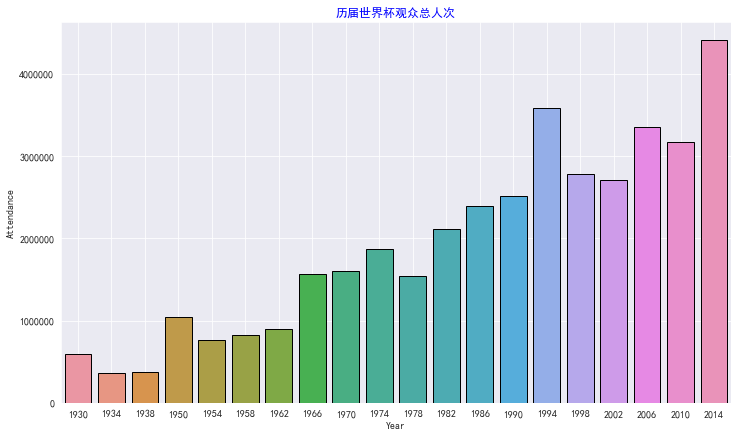

In [79]:
att = matches.groupby("Year")["Attendance"].sum().reset_index()
sns.set_style("darkgrid")
plt.figure(figsize=(12,7))
# 输出图片
sns.barplot(att["Year"],att["Attendance"],linewidth=1,edgecolor="k"*len(att))
plt.grid(True)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title("历届世界杯观众总人次",color='b')
plt.show()

在世界杯举办早期，由于客观条件的限制，现场观众人数并不是特别多，随着经济全球化以及交通方式的更新发展，越来越多的人能够获得在现场观看世界杯的机会，在2014年巴西世界杯全部64场比赛中，观众总人次突破400万

## 2.2 单场平均人数

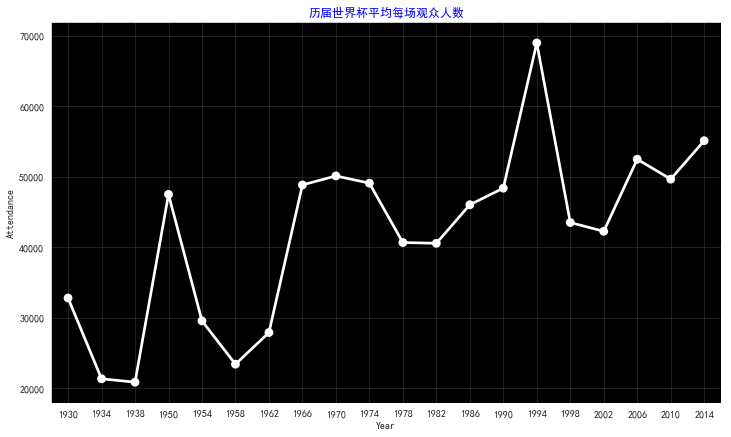

In [80]:
att1 = matches.groupby("Year")["Attendance"].mean().reset_index()
att1["Year"] = att1["Year"].astype(int)
plt.figure(figsize=(12,7))
ax = sns.pointplot(att1["Year"],att1["Attendance"],color="w")
ax.set_facecolor("k")
plt.grid(True,color="grey",alpha=.3)
plt.title("历届世界杯平均每场观众人数",color='b')
plt.show()

虽然2014年世界杯创造了总观众人数的记录，但是平均观众人数最多的一届世界杯却是在1994年的美国世界杯，平均每场人均超过7万，足以看出美国人民喜欢人多凑热闹的传统。（毕竟足球不算美国的大众运动，上座率如此高，并不能说明真心热爱足球）

In [81]:
# 增加一个对阵列
matches["VS"] = matches["Home Team Name"] + " .Vs.  " + matches["Away Team Name"]
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Referee,VS
0,1930,13 Jul 1930,Group 1,Pocitos,Montevideo,France,4,1,Mexico,4444,LOMBARDI Domingo (URU),France .Vs. Mexico
1,1930,13 Jul 1930,Group 4,Parque Central,Montevideo,USA,3,0,Belgium,18346,MACIAS Jose (ARG),USA .Vs. Belgium
2,1930,14 Jul 1930,Group 2,Parque Central,Montevideo,Yugoslavia,2,1,Brazil,24059,TEJADA Anibal (URU),Yugoslavia .Vs. Brazil
3,1930,14 Jul 1930,Group 3,Pocitos,Montevideo,Romania,3,1,Peru,2549,WARNKEN Alberto (CHI),Romania .Vs. Peru
4,1930,15 Jul 1930,Group 1,Parque Central,Montevideo,Argentina,1,0,France,23409,REGO Gilberto (BRA),Argentina .Vs. France


## 2.3 单场人数之最

In [82]:
# 按照观众人数进行排序
h_att = matches.sort_values(by="Attendance",ascending=False)[:20]

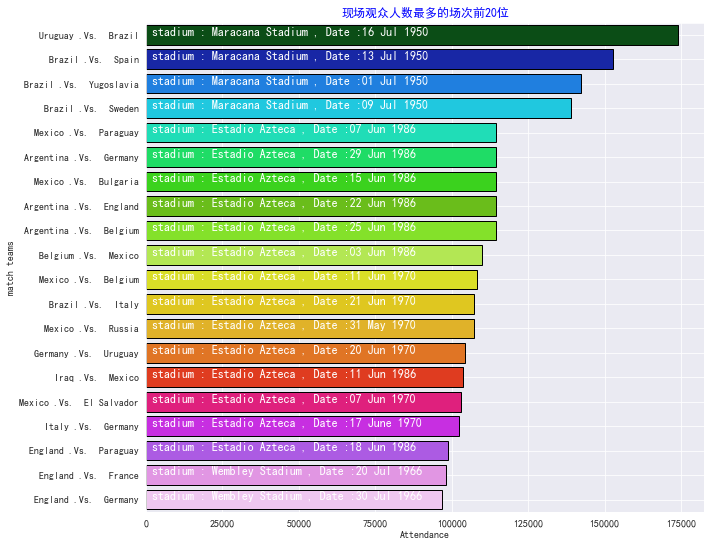

In [83]:
plt.figure(figsize=(10,9))
ax = sns.barplot(y = h_att["VS"],x = h_att["Attendance"],palette="gist_ncar",
                 linewidth = 1,edgecolor="k"*len(h_att))
plt.ylabel("match teams")
plt.xlabel("Attendance")
plt.title("现场观众人数最多的场次前20位",color='b')
plt.grid(True)
for i,j in enumerate(" stadium : " + h_att["Stadium"]+" , Date :" + h_att["Datetime"]):
    ax.text(.7,i,j,fontsize = 12,color="white",weight = "bold")
plt.show()

以上的统计图可能会让很多不是球迷的朋友瞠目结舌、不敢相信，但这就是事实。

世界杯历史上单场观众人数最多的比赛是1950年巴西世界杯的决赛巴西VS乌拉圭，现场人数超过17万，而在很多非官方的报道中，该场比赛涌入了超过20万的球迷，足以说明南美的足球狂热氛围。我们可以简单对比一下，北京工人体育场满员最多坐5万人，1950年的决赛相当于三四个工体，只能用恐怖来形容。但不幸的是，在这场决赛中，巴西最终被乌拉圭逆转1-2输掉了首次赢得世界杯的机会，这场比赛亦被称为“马拉卡纳惨案”或“世纪惨案”，而比赛日1950年7月16日成为了整个巴西的“国难日”。

除了世界上最大的球场马拉卡纳之外，墨西哥的首都墨西哥城的阿兹台克球场同样令人震惊，由于墨西哥举办过1970、1986两届世界杯大赛，并且也正好赶上了两代球王贝利（1970）、马拉多纳（1986）的巅峰，所以阿兹台克球场的上座率也非常高。与这两座“BUG”级别的球场相比，英国人心中的足球“圣地”温布利显得并没有那么突出了。

## 2.4 球场平均上座人数之最

In [84]:
# 统计观众人数由高到低的球场
std  = matches.groupby(["Stadium","City"])["Attendance"].mean().reset_index().sort_values(by = "Attendance",ascending =False)

In [85]:
std.head()

,Stadium,City,Attendance
99,Maracana Stadium,Rio De Janeiro,101692.625000
32,Estadio Azteca,Mexico City,100923.684211
137,Rose Bowl,Los Angeles,92600.875000
179,Wembley Stadium,London,86448.222222
151,Soccer City Stadium,Johannesburg,83857.375000


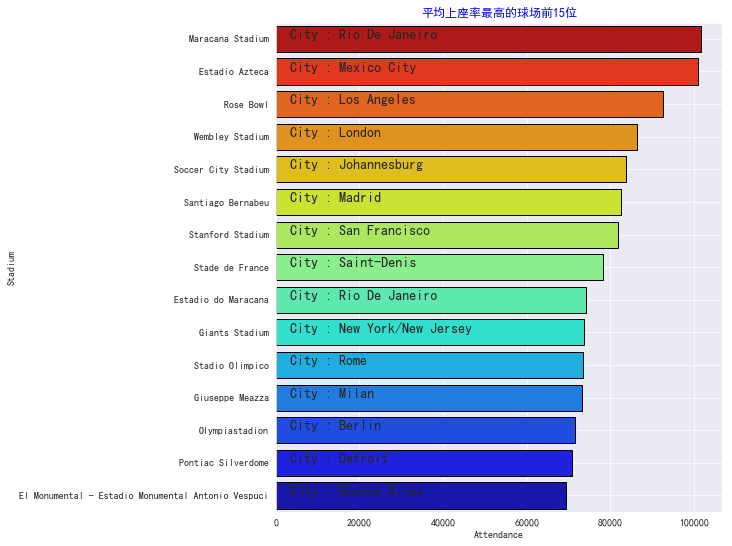

In [86]:
plt.figure(figsize=(8,9))
ax = sns.barplot(y = std["Stadium"][:15],x = std["Attendance"][:15],palette="jet_r",
                 linewidth=1,edgecolor = "k"*14)
plt.grid(True)

for i,j in enumerate("  City : " + std["City"][:15]):
    ax.text(.7,i,j,fontsize=14)

plt.title("平均上座率最高的球场前15位",color='b')
plt.show()


巴西里约热内卢的马拉卡纳球场和墨西哥的阿兹台克球场排名前两位当之无愧，平均上座率都超过了10万人，这是一个非常恐怖的数据，也足以说明这两个国家的人民对足球的热情。而排在其后的美国洛杉矶的玫瑰碗、英国伦敦的温布利、南非约翰内斯堡的足球城、西班牙马德里的伯纳乌都是世界足球迷心中的“圣殿”。

值得一提的是，这些球场上座率高的另外一个原因就是其都是本国的地标性建筑和体育场地，众多吸引眼球的、关键的比赛场次均会放在该场地进行，故而影响力较大，其实除了这些球场之外，也有非常著名的球场，比如西班牙巴塞罗那的诺坎普，由于不是首都球场，举办的世界杯比赛较少，故而上座率没有那么高，但这也不妨碍其成为世界级球场之一

# 3.世界杯参赛球队历史数据统计

## 3.1 参赛总场次

In [21]:
# 主队
ht = matches["Home Team Name"].value_counts().reset_index()
ht.columns = ["team","matches"]
# 客队
at = matches["Away Team Name"].value_counts().reset_index()
at.columns = ["team","matches"]
# 将主队与客队对应的场次数合并，并按照场次数降序排序
mt = pd.concat([ht,at],axis=0)
mt = mt.groupby("team")["matches"].sum().reset_index().sort_values(by="matches",ascending=False)

In [22]:
# 总场次
mt.head(3)

,team,matches
29,Germany,110
8,Brazil,108
39,Italy,83


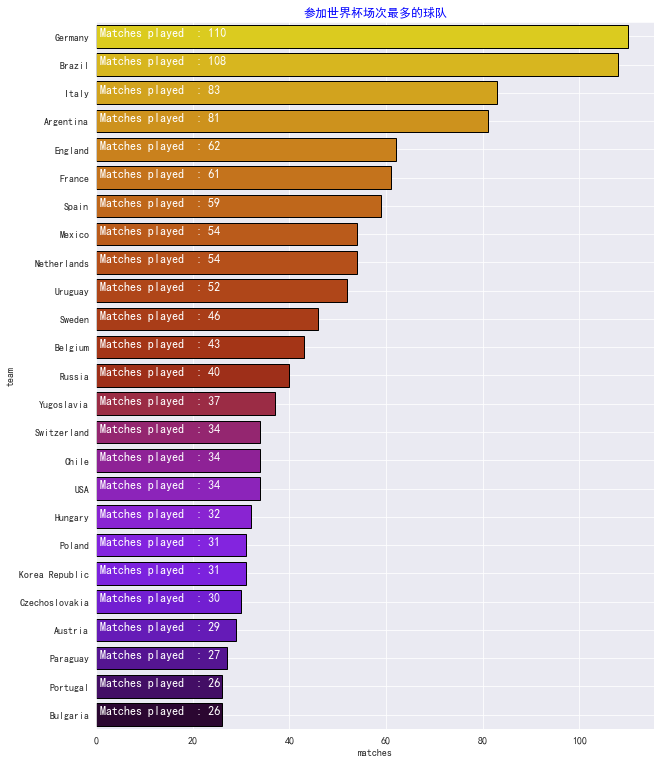

In [23]:
plt.figure(figsize=(10,13))
ax = sns.barplot("matches","team",data=mt[:25],palette="gnuplot_r",
                 linewidth=1,edgecolor="k"*25)
plt.grid(True)
plt.title("参加世界杯场次最多的球队",color='b')
for i,j in enumerate("Matches played  : " + mt["matches"][:25].astype(str)):
    ax.text(.7,i,j,fontsize=12,color="white")

+ 仅有巴西和德国世界杯的参赛场次超过了百场，足可见这两个国家队在世界杯舞台上的深厚底蕴。


+ 我们在数据预处理阶段说过，德国队的参赛场次包含了两德统一前联邦德国（即西德）的数据，没有包含民主德国（即东德）的数据。原因首先是民主德国只参加过1974年一届世界杯，数据量很小，其次民主德国现已不存在，其历史数据应当以一个独立的个体存在，而不应属于任何其他国家。


+ 世界杯比赛场次越多，证明该国家队参加世界杯的次数就越多，一般而言实力就越强，这在上图中可以很好的反映出来，排名靠前的国家队基本都是世界杯冠军的有力争夺者。唯一的例外可能是墨西哥队，其世界杯场次截止到2014年共54场，甚至比两届冠军乌拉圭都要多。原因主要因为墨西哥队成绩非常稳定，是世界杯的常客，并且从1994年开始，连续8届世界杯打进16强，然后被淘汰；而乌拉圭队在世界杯早期两次夺冠后，曾陷入几十年的萎靡期，最近十年才稍有回暖，但早已不是当年那个可以制造巴西队“世纪惨案”的王者之师了。

## 3.2 世界杯历史战绩排名

In [24]:
"""
定义两个函数，目的用来获取mathces数据集中的获胜球队与失利球队
"""

def win_label(matches):
    if matches["Home Team Goals"] > matches["Away Team Goals"]:
        return matches["Home Team Name"]
    if matches["Home Team Goals"] < matches["Away Team Goals"]:
        return matches["Away Team Name"]
    if matches["Home Team Goals"] == matches["Away Team Goals"]:
        return "DRAW"
    
def lost_label(matches):
    if matches["Home Team Goals"] < matches["Away Team Goals"]:
        return matches["Home Team Name"]
    if matches["Home Team Goals"] > matches["Away Team Goals"]:
        return matches["Away Team Name"]
    if matches["Home Team Goals"] == matches["Away Team Goals"]:
        return "DRAW"
# 获胜球队
matches["win_team"]  = matches.apply(lambda matches:win_label(matches),axis=1)
# 失利球队
matches["lost_team"] = matches.apply(lambda matches:lost_label(matches),axis=1)

In [25]:
matches.head(3)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Referee,VS,win_team,lost_team
0,1930,13 Jul 1930,Group 1,Pocitos,Montevideo,France,4,1,Mexico,4444,LOMBARDI Domingo (URU),France .Vs. Mexico,France,Mexico
1,1930,13 Jul 1930,Group 4,Parque Central,Montevideo,USA,3,0,Belgium,18346,MACIAS Jose (ARG),USA .Vs. Belgium,USA,Belgium
2,1930,14 Jul 1930,Group 2,Parque Central,Montevideo,Yugoslavia,2,1,Brazil,24059,TEJADA Anibal (URU),Yugoslavia .Vs. Brazil,Yugoslavia,Brazil


In [26]:
lost = matches["lost_team"].value_counts().reset_index()
win = matches["win_team"].value_counts().reset_index()
# 将获胜与失利场次合并到一个dataframe
wl  = win.merge(lost,left_on="index",right_on="index",how="left")
wl = wl[wl["index"] != "DRAW"]
wl.columns  = ["team","wins","loses"]

In [27]:
wl.head(3)

,team,wins,loses
1,Brazil,71,19
2,Germany,70,20
3,Italy,45,17


In [28]:
wl1 = wl.copy()
# 将总场次'mt'合并到'wl'中
wl1 = wl1.merge(mt,left_on="team",right_on="team",how="left")
# 平局 = 总场次 - （胜场 + 负场）
wl1["draws"] = wl1["matches"]-(wl1["wins"]+wl1["loses"])
wl1.index = wl1.team
wl1 = wl1[['team','wins','draws','loses','matches']]
# 按照胜场、平局的顺序升序排序
wl1 = wl1.sort_values(by=["wins","draws"],ascending=True)

In [29]:
# 国家队世界杯战绩
wl1.tail(8)

,team,wins,draws,loses,matches
team,,,,,
England,England,26,20,16,62
France,France,29,12,20,61
Spain,Spain,29,12,18,59
Netherlands,Netherlands,29,14,11,54
Argentina,Argentina,44,15,22,81
Italy,Italy,45,21,17,83
Germany,Germany,70,20,20,110
Brazil,Brazil,71,18,19,108


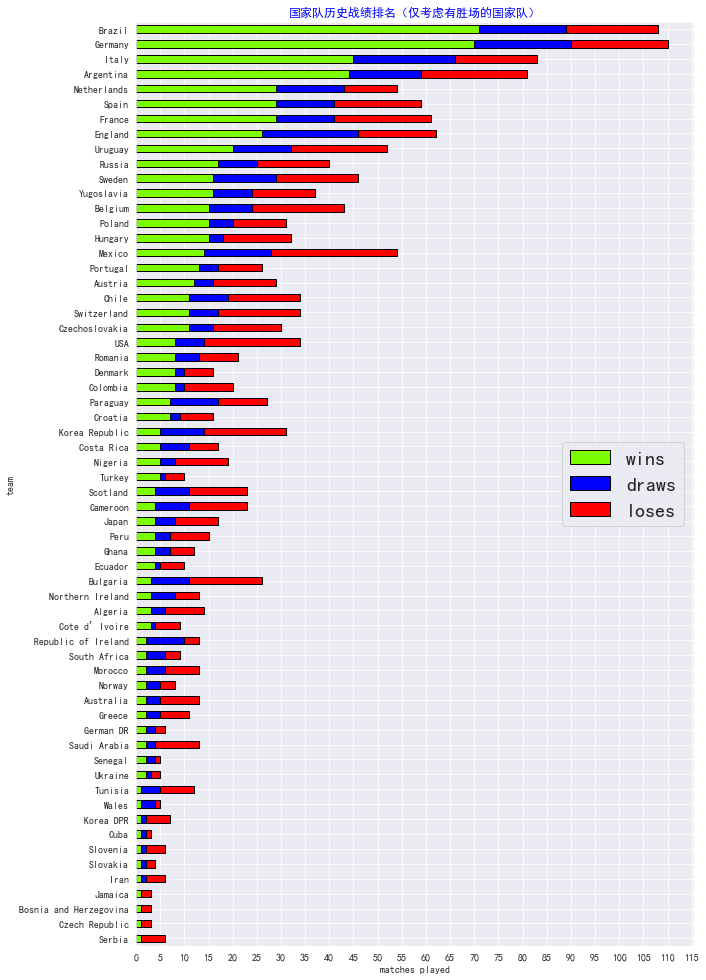

In [30]:
wl1[["wins","draws","loses"]].plot(kind="barh",stacked=True,figsize=(10,17),
                                 colors=["lawngreen","blue","r"],
                                  linewidth=1,edgecolor="k"*len(wl1))
plt.legend(loc="center right",prop={"size":20})
plt.xticks(np.arange(0,120,5))
plt.title("国家队历史战绩排名（仅考虑有胜场的国家队）",color='b')
plt.xlabel("matches played")
plt.show()

巴西与德国，不仅是参加世界杯场次最多的球队，也是获胜次数最多的球队，排在其身后的是意大利与阿根廷，这四支国家队也是世界杯历史上夺冠次数最多的球队。

排在第五名的荷兰队，比较悲催，虽然历史战绩优于英格兰、法国、西班牙、乌拉圭，却没有拿过冠军

Text(0.5, 1.0, '国家队世界杯累积平局场次')

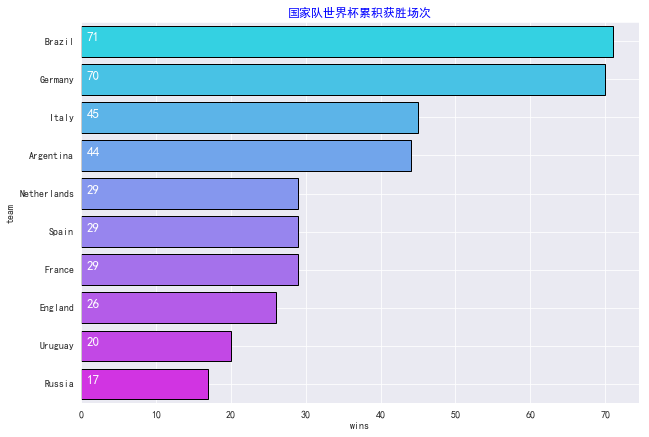

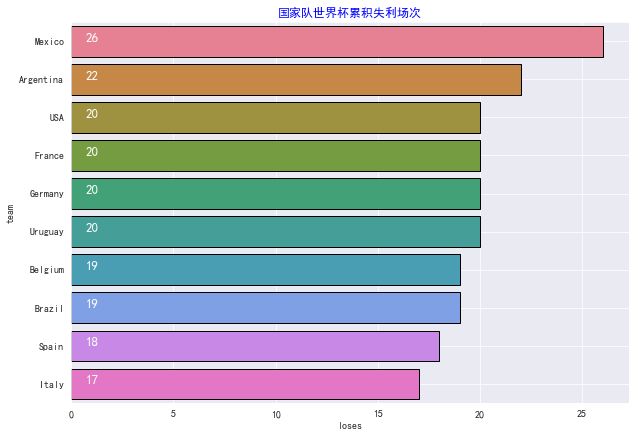

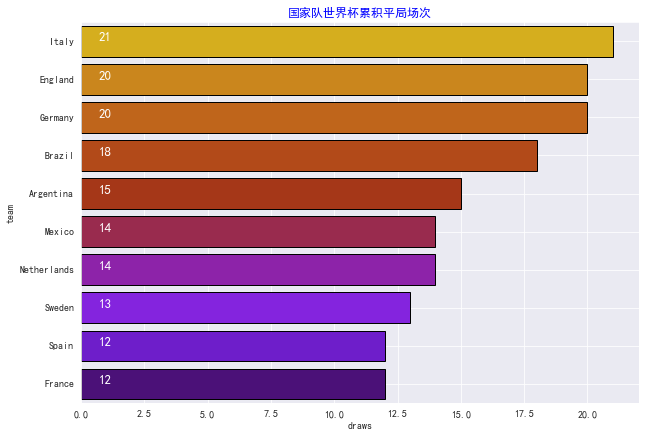

In [31]:
"""
分别作出世界杯累积获胜、失利、平局场次的前十名柱状图
"""
plt.figure(figsize=(10,7))
ax = sns.barplot("wins","team",data=wl1.sort_values(by="wins",ascending=False)[:10],linewidth=1,edgecolor="k"*10,palette="cool")
for k,l in enumerate(wl1.sort_values(by="wins",ascending=False)[:10]["wins"]):
    ax.text(.7,k,l,fontsize=13,color='w')
plt.grid(True)
plt.title("国家队世界杯累积获胜场次",color='b')

plt.figure(figsize=(10,7))
ax = sns.barplot("loses","team",data=wl1.sort_values(by="loses",ascending=False)[:10],linewidth=1,edgecolor="k"*10,palette="husl")
for k,l in enumerate(wl1.sort_values(by="loses",ascending=False)[:10]["loses"]):
    ax.text(.7,k,l,fontsize=13,color='w')
plt.grid(True)
plt.title("国家队世界杯累积失利场次",color='b')

plt.figure(figsize=(10,7))
ax = sns.barplot("draws","team",data=wl1.sort_values(by="draws",ascending=False)[:10],linewidth=1,edgecolor="k"*10,palette="gnuplot_r")
for k,l in enumerate(wl1.sort_values(by="draws",ascending=False)[:10]["draws"]):
    ax.text(.7,k,l,fontsize=13,color='w')
plt.grid(True)
plt.title("国家队世界杯累积平局场次",color='b')

若想在上述三个榜单中称王，没有足够的世界杯参赛次数是不可能的。所以我们会发现三个榜单的重合度其实很高，因为都是参加世界杯场次较多的球队才会有机会。而且普遍是欧洲与南美的国家队，这也是因为这两个地区一直是现代足球的中心，唯二的例外是来自中北美地区的墨西哥与美国，亚洲与非洲则没有球队入选榜单。

## 3.3 世界杯参赛球队历史战绩对比

我们准备从场次数、进球数、胜负平场次数共五个方面来对历史上的参赛球队进行对比，为了便于进球数的比较，我们先统计出进球数据：

In [32]:
# 主队进球数据
goals_home = matches.groupby("Home Team Name")["Home Team Goals"].sum().reset_index()
goals_home.columns = ["team","goals"]
# 客队进球数据
goals_away = matches.groupby("Away Team Name")["Away Team Goals"].sum().reset_index()
goals_away.columns = ["team","goals"]
# 全部进球数据
total_goals = pd.concat([goals_home,goals_away],axis=0)
total_goals = total_goals.groupby("team")["goals"].sum().reset_index()
# 进球数降序排列
total_goals = total_goals.sort_values(by="goals",ascending =False)

# total_goals

In [33]:
total_goals.head()

,team,goals
29,Germany,235
8,Brazil,225
2,Argentina,133
39,Italy,128
27,France,108


In [34]:
"""
总战绩名单：汇总了每支参赛球队的战绩信息，包括场次、进球、胜负平等，按照胜、平、进球数排序
"""
matches_played = mt.copy()
mat_new = matches_played.merge(lost,left_on="team",right_on="index",how="left")
mat_new = mat_new.merge(win,left_on="team",right_on="index",how="left")
mat_new = mat_new[["team","matches","lost_team","win_team"]]
mat_new = mat_new.fillna(0)
mat_new["win_team"] = mat_new["win_team"].astype(int)
mat_new["draws"] = (mat_new["matches"]) - (mat_new["lost_team"] + mat_new["win_team"])
mat_new = mat_new.merge(total_goals,left_on="team",right_on="team",how="left")
mat_new = mat_new.rename(columns={"win_team":"wins","lost_team":"loses"})
mat_new = mat_new[['team','wins','draws','loses','goals','matches']]
mat_new = mat_new.sort_values(by=["wins","draws","goals"],ascending=False)

In [35]:
mat_new.tail()

,team,wins,draws,loses,goals,matches
71,Iraq,0,0,3,1,3
75,China PR,0,0,3,0,3
76,Canada,0,0,3,0,3
78,Zaire,0,0,3,0,3
79,Dutch East Indies,0,0,1,0,1


输出这份战绩名单的最后五位，赫然看见了又熟悉又陌生的身影。熟悉的不用多说，陌生的则是扎伊尔（Zaire）和荷属东印度群岛（Dutch East Indies），因为这两个国家和地区都改名了，扎伊尔是如今的刚果民主共和国，荷属东印度群岛则是印度尼西亚。值得一提的是，亚洲球队最早参加世界杯是在1938年，参赛队就是荷属东印度群岛。

为了更好的进行球队之间的对比，我们定义一个函数：

In [36]:
"""
历史战绩对比函数：输入为国家队名称，输出为场次、进球、胜、负、平的对比图
"""
def team_compare(team1,team2):
    
    lst = [team1,team2]
    dat = mat_new[mat_new["team"].isin(lst)]
    
    plt.figure(figsize=(12,10))
    cols   = ["matches","goals","wins","loses","draws"]
    length = len(cols)
    
    for i,j in itertools.zip_longest(cols,range(length)):
        
        fig = plt.subplot(3,2,j+1)
        ax  = sns.barplot(dat[i],dat["team"],palette=["royalblue","r"],
                         linewidth=2,edgecolor="k"*len(lst))
        plt.ylabel("")
        plt.yticks(fontsize=13)
        plt.grid(True,color="grey",alpha=.3)
        plt.title(i,color="b",fontsize=15)
        plt.subplots_adjust(wspace = .3,hspace =.5)
        fig.set_facecolor("w")
        
        for k,l in enumerate(dat[i].values):
            ax.text(.7,k,l,weight = "bold",fontsize = 20)

**通过`team_compare(team1, team2)`函数，我们可以输入任意两个国家的名称，获取这两个国家在历史战绩方面的直观比较**<br>

下面就是我们通过对比各大洲之间代表球队的战绩所获得的直观图：

+ **巴西与德国**：世界杯上最具有实力的两支国家队，其各项数据对比近乎不相上下

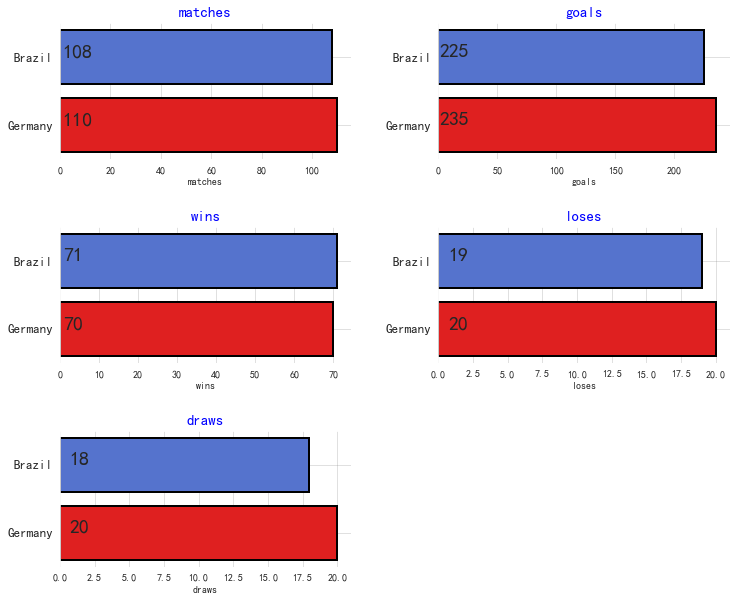

In [37]:
team_compare("Germany","Brazil")

+ **德国意大利**：欧洲大陆的两支宿敌球队，德意两国均四次捧得世界杯

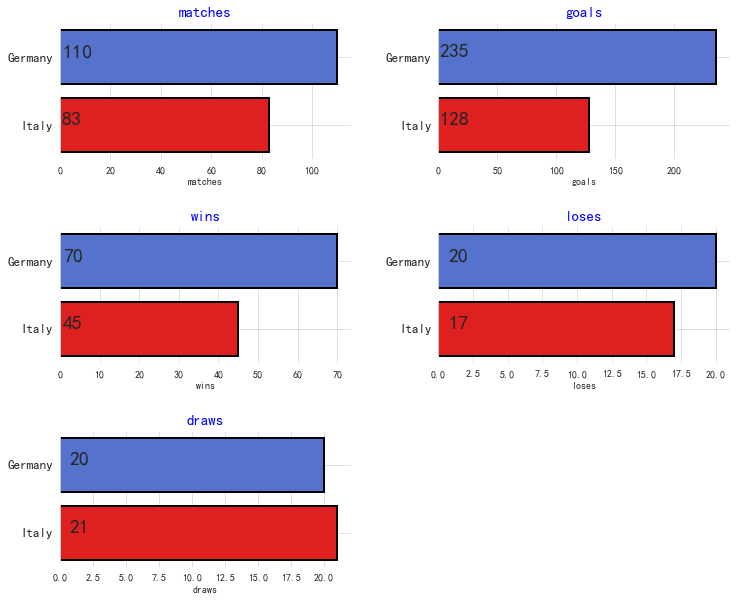

In [38]:
team_compare("Germany","Italy")

+ **巴西法国**：纵使巴西队在数据方面碾压法国，可在与法国队的直接对抗中，却很难占到便宜，上次巴西队在世界杯上战胜法国，还是1958年的事了。

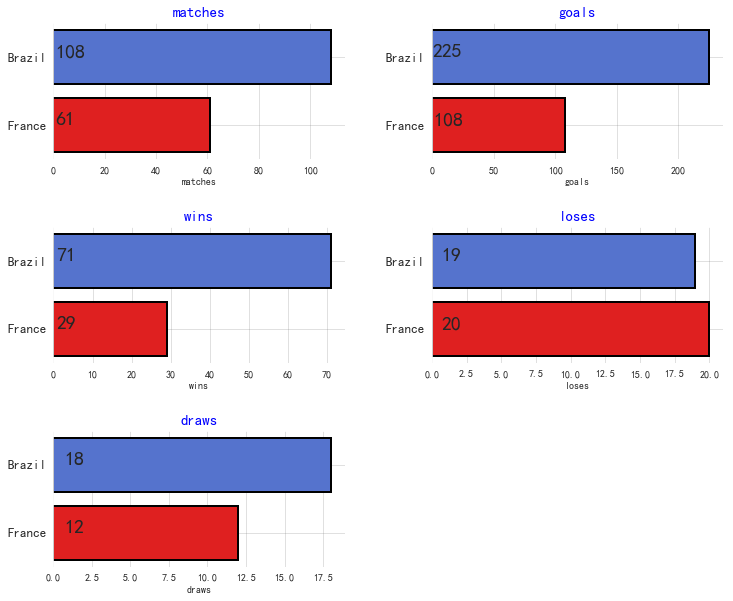

In [39]:
team_compare("France","Brazil")

+ **巴西阿根廷**：美洲大陆乃至全世界最令人血脉喷张的对决——巴阿大战，巴西总统说：“除了足球，我们与阿根廷在任何方面都可以合作。”

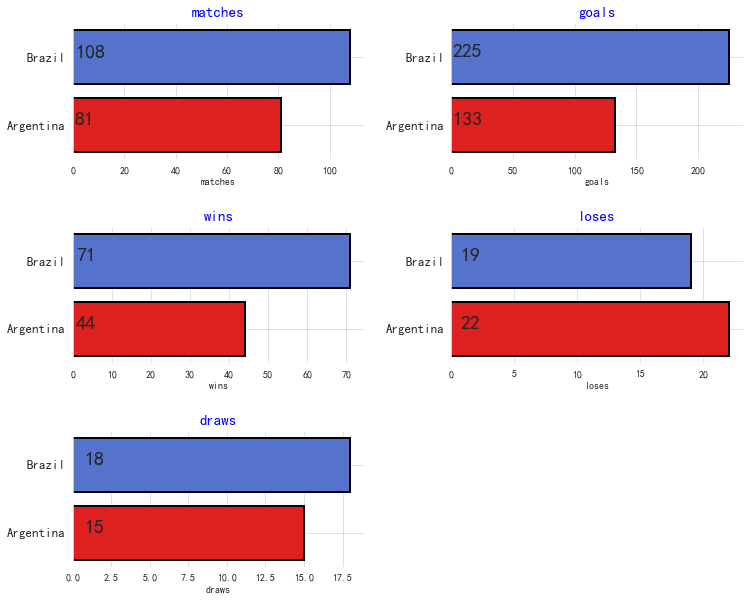

In [40]:
team_compare("Argentina","Brazil")

+ **韩国日本**：亚洲在世界杯上表现最好的两支队伍，但显然还有很大的进步空间

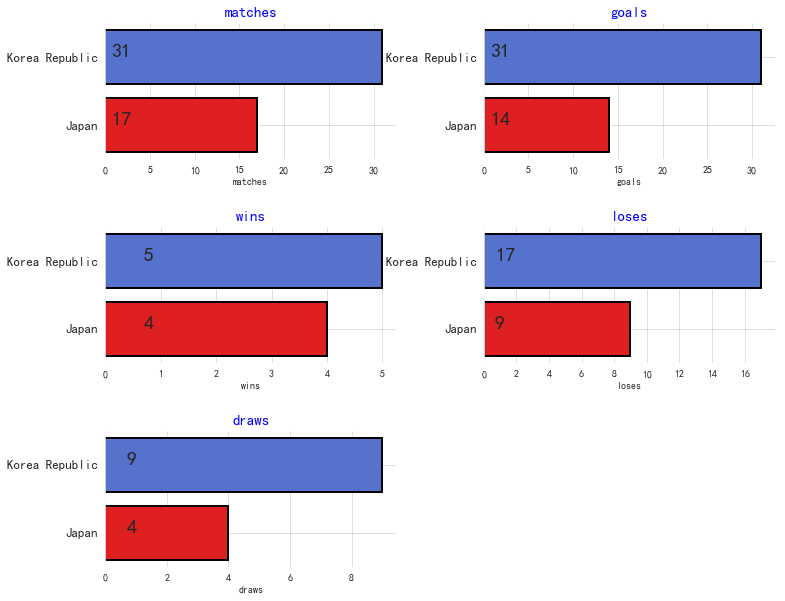

In [45]:
team_compare("Japan","Korea Republic")

+ **美国墨西哥**：中北美赛场上，墨西哥与美国的争雄永远是主旋律

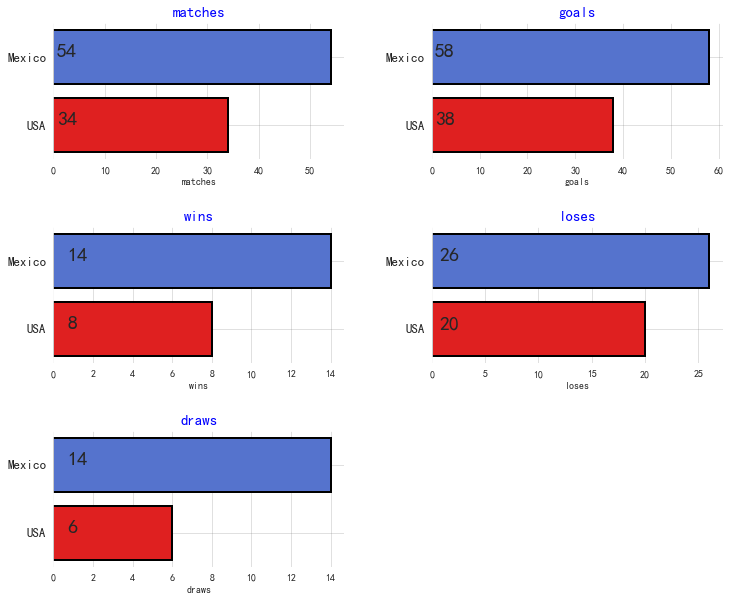

In [44]:
team_compare("Mexico","USA")

+ **尼日利亚喀麦隆**：非洲球队从来不是世界杯的看客，他们也曾创造辉煌，“超级雄鹰”尼日利亚与“非洲雄狮”喀麦隆就是他们的代表

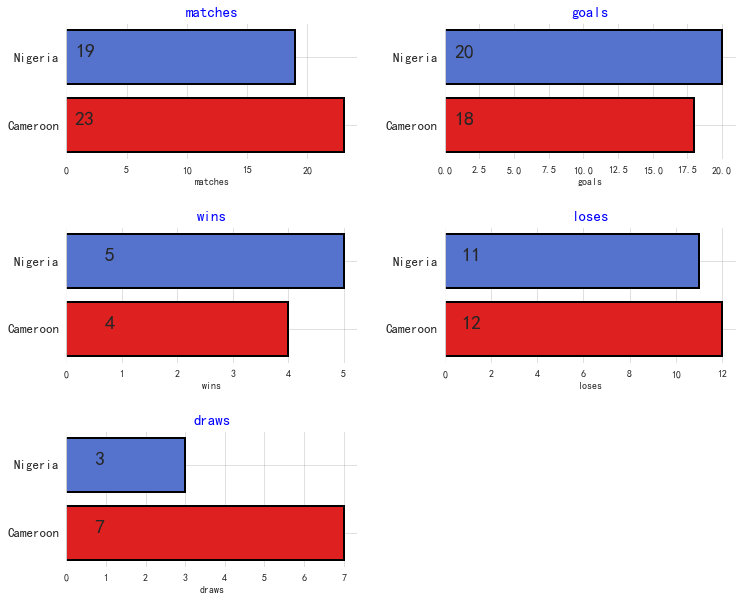

In [42]:
team_compare("Cameroon","Nigeria")

+ **中国！！！**：至于为什么不提中国队，原因很简单，大写的鸭蛋让人尴尬。。。

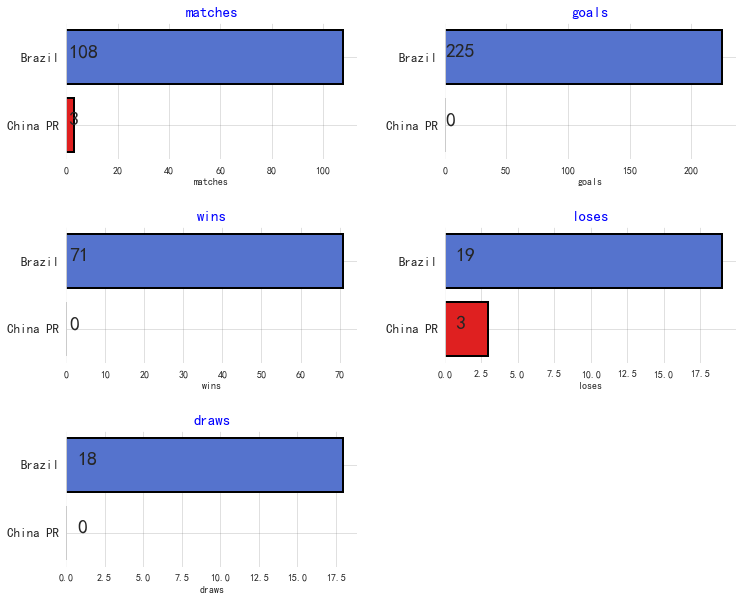

In [43]:
team_compare("China PR","Brazil")

# 4.球场上的法官——裁判

+ 裁判毕竟也是出现在球场上的“物体”，也配拥有姓名，对没听错，就是“物体”，因为从规则来说，裁判不算人，而是跟门柱、角旗杆一样的东西

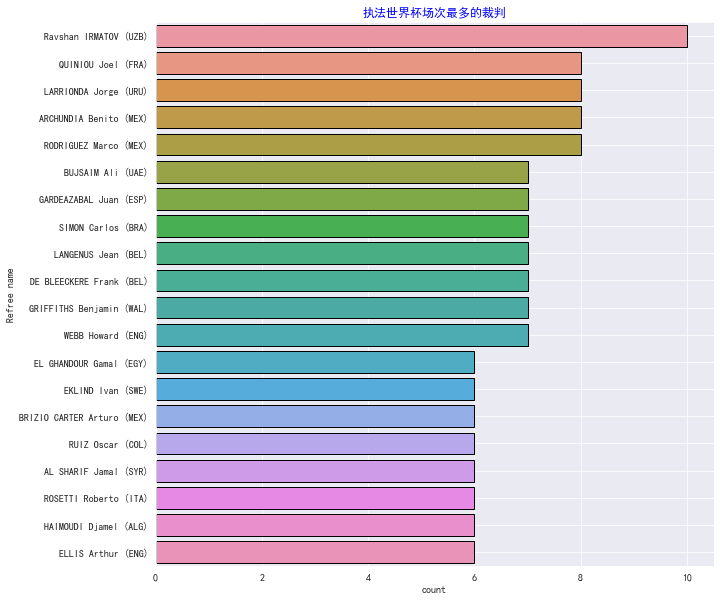

In [46]:
ref = matches["Referee"].value_counts().reset_index()
ref = ref.sort_values(by="Referee",ascending=False)

plt.figure(figsize=(10,10))
sns.barplot("Referee","index",data=ref[:20],linewidth=1,edgecolor="k"*20)
plt.xlabel("count")
plt.ylabel("Refree name")
plt.grid(True)
plt.title("执法世界杯场次最多的裁判",color='b')
plt.show()

+ 显然在裁判的领域，与国家足球水平的高低就没有直接联系了，执法世界杯比赛最多的裁判是来自**亚洲**乌兹别克斯坦的**伊尔马托夫**，这位“亚洲金哨”共执法了十场世界杯的比赛，要知道，乌兹别克斯坦自从苏联解体独立以来，还没有参加过一场世界杯正赛！

# 5.冠亚及四强球队统计

导入`cups`数据集，其数据集中包括历届世界杯四强名单，其主要信息如下：

| 列名 | 含义说明 |
| :--: | -- |
| **Year** | 年份 |
| **Country** | 东道主 |
|**Winner**|冠军|
|**Runners-Up**|亚军|
|**Thrid**|季军|
|**Fourth**|殿军|
|**GoalsScored**|总进球|
|**QualifiedTeams**|球队总数|
|**MatchesPlayed**|场次总数|
|**Attendance**|观众总数|

In [51]:
cups = pd.read_csv("./fifa-world-cup/WorldCups.csv")
cups.head(10)

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363.000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607
5,1958,Sweden,Brazil,Sweden,France,Germany FR,126,16,35,819.810
6,1962,Chile,Brazil,Czechoslovakia,Chile,Yugoslavia,89,16,32,893.172
7,1966,England,England,Germany FR,Portugal,Soviet Union,89,16,32,1.563.135
8,1970,Mexico,Brazil,Italy,Germany FR,Uruguay,95,16,32,1.603.975
9,1974,Germany,Germany FR,Netherlands,Poland,Brazil,97,16,38,1.865.753


+ 同样地，我们需要把一些如今已经不存在的国家替换一下，如“Germany FR”变为“Germany”，“Soviet Union”更换为“Russia”

## 5.1 历届参赛队伍数量与比赛场次

In [52]:
cups = cups.replace("Germany FR","Germany")
cups = cups.replace("Soviet Union","Russia")

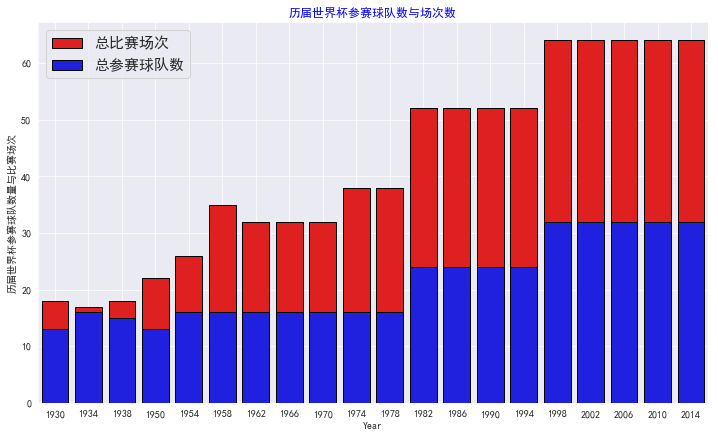

In [50]:
plt.figure(figsize=(12,7))
sns.barplot(cups["Year"],cups["MatchesPlayed"],linewidth=1,
            edgecolor="k"*len(cups),color="r",label="总比赛场次")
sns.barplot(cups["Year"],cups["QualifiedTeams"],linewidth=1,
            edgecolor="k"*len(cups),color="b",label="总参赛球队数")
plt.legend(loc="best",prop={"size":15})
plt.title("历届世界杯参赛球队数与场次数",color='b')
plt.grid(True)
plt.ylabel("历届世界杯参赛球队数量与比赛场次")
plt.show()

+ 世界杯早期，参赛队伍少、赛制不确定，随着比赛赛制的完善和规模的扩军，如今世界杯确定了32支参赛队、共64场比赛的模式。而在未来2022年卡塔尔世界杯上，世界杯将再次扩军到48支球队

## 5.2 冠军球队

In [55]:
cups["Year1"] = cups["Year"].astype(str)
c1  = cups.groupby("Winner")["Year1"].apply(" , ".join).reset_index()
c2  = cups.groupby("Winner")["Year"].count().reset_index()
c12 = c1.merge(c2,left_on="Winner",right_on="Winner",how="left")
c12 = c12.sort_values(by = "Year",ascending =False)

In [56]:
# 冠军汇总
c12.head()

,Winner,Year1,Year
1,Brazil,"1958 , 1962 , 1970 , 1994 , 2002",5
4,Germany,"1954 , 1974 , 1990 , 2014",4
5,Italy,"1934 , 1938 , 1982 , 2006",4
0,Argentina,"1978 , 1986",2
7,Uruguay,"1930 , 1950",2


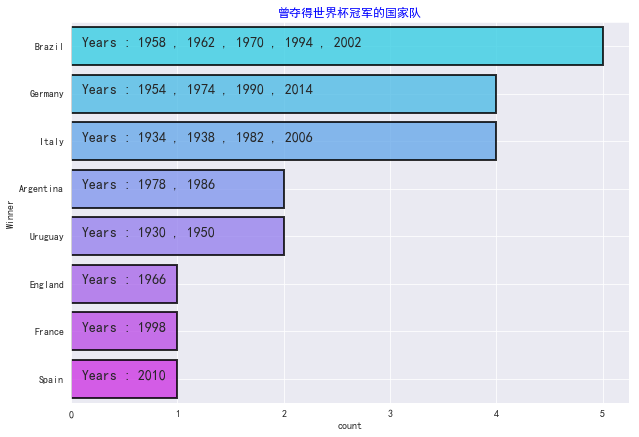

In [57]:
plt.figure(figsize=(10,7))
ax = sns.barplot("Year","Winner",data=c12,
            palette="cool",
            alpha=.8,
            linewidth=2,
            edgecolor="k"*len(c12))
for i,j in enumerate("Years : " + c12["Year1"]):
    ax.text(.1,i,j,weight = "bold",fontsize=14)

plt.title("曾夺得世界杯冠军的国家队",color='b')
plt.grid(True)
plt.xlabel("count")
plt.show()

由于数据集的数据只到2014年，故2018年俄罗斯世界杯冠军法国队的成绩没有全部加进去，但是大家应该知道，法国的夺冠次数也是两次了，详细信息可以参阅国际足联官方网站-->[FIFA](https://www.fifa.com)

## 5.3 曾进决赛球队

In [58]:
"""
分别汇总冠军和亚军球队，整合为打进决赛的球队
"""
#　冠军
cou = cups["Winner"].value_counts().reset_index()
cou_w = cou.copy()
cou_w.columns = ["country","count"]
cou_w["type"] = "WINNER"

# 亚军
cou_r = cups["Runners-Up"].value_counts().reset_index()
cou_r.columns = ["country","count"]
cou_r["type"] = "RUNNER - Up"

# 曾进决赛
cou_t = pd.concat([cou_w,cou_r],axis=0)


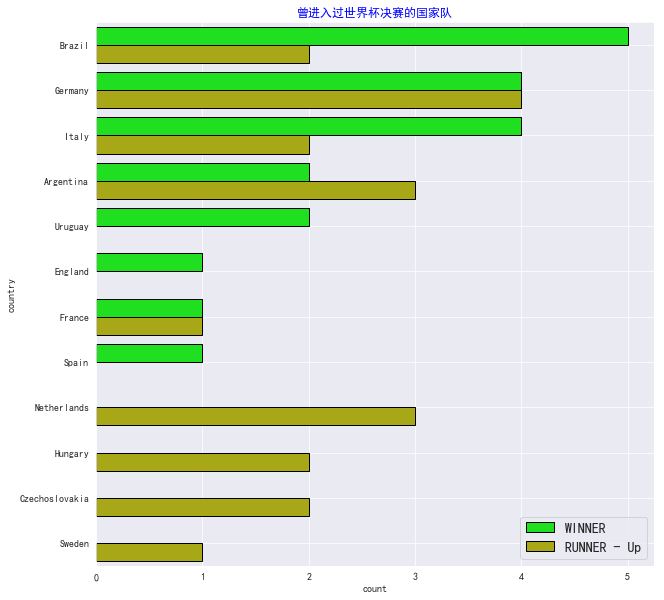

In [61]:
plt.figure(figsize=(10,10))
sns.barplot("count","country",data=cou_t,
            hue="type",palette=["lime","y"],
            linewidth=1,edgecolor="k"*len(cou_t))
plt.grid(True)
plt.legend(loc="lower right",prop={"size":14})
plt.title("曾进入过世界杯决赛的国家队",color='b')
plt.show()

+ 在世界杯近90年的时间里，能够夺冠的球队总共只有8支，分别是乌拉圭、意大利、德国（包括联邦德国）、巴西、英格兰（注意跟英国区别开）、阿根廷、法国、西班牙，即便算上进入决赛的队伍，也不过12支而已，由此可见世界杯的竞争力之大，只有少数几个国家队有争冠的实力，正因如此，世界杯的比赛才极具吸引力。

+ 巴西和德国是世界杯上最成功的球队，分别7次和8次打入世界杯决赛，巴西5次夺冠，德国4次。同时意大利也曾4次夺冠，但进入决赛的次数是6次，此外阿根廷队也5次进入决赛，2次问鼎。

+ 世界杯上最悲情的球队莫过于荷兰，荷兰队曾3次打进世界杯决赛，尤其是20世纪70年代，在1974、78连续两届比赛中均战斗到最后一刻，可是全部失利，只能无奈接受“无冕之王”的嘲讽。


## 5.4 曾进四强球队

In [62]:
"""
整合季军与殿军次数
"""
thrd = cups["Third"].value_counts().reset_index()
thrd.columns = ["team","count"]
thrd["type"] = "THIRD PLACE"

frth = cups["Fourth"].value_counts().reset_index()
frth.columns = ["team","count"]
frth["type"] = "FOURTH PLACE"

plcs = pd.concat([thrd,frth],axis=0)

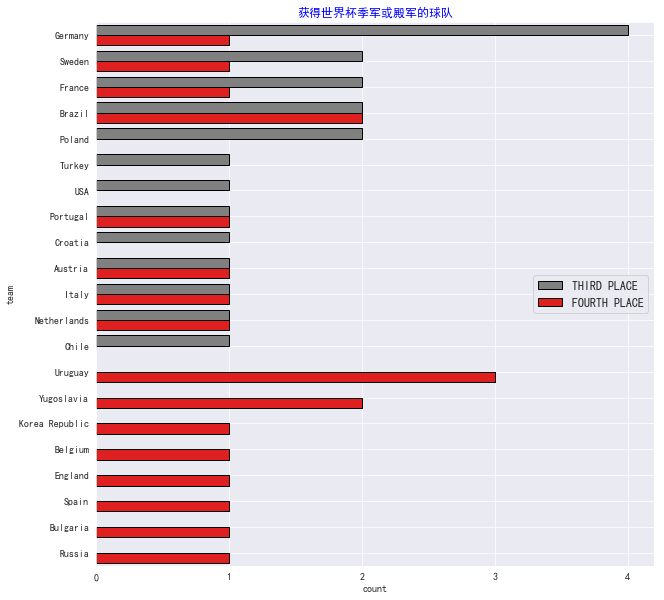

In [64]:
plt.figure(figsize=(10,10))
sns.barplot("count","team",data=plcs,hue="type",
           linewidth=1,edgecolor="k"*len(plcs),
           palette = ["grey","r"])
plt.grid(True)
plt.xticks(np.arange(0,5,1))
plt.title("获得世界杯季军或殿军的球队",color='b')
plt.legend(loc="best",prop={"size":12})
plt.show()

+ 在上图中我们可以看到，曾打进四强的国家队要比进入决赛的国家队数量高出不少，并且其中包括一些相对而言不算传统豪强的球队（只是相对夺冠球队），例如美国、奥地利、克罗地亚、智利、土耳其、波兰、南斯拉夫（已分裂）、保加利亚等，此外韩国队曾在2002年世界杯打进过四强，但是懂的人自然懂，不过多评论

希望通过这次案例的演示，大家在熟悉绘图技巧的同时，也能对曾经这些世界杯上的历史也有一点点的了解，毕竟这也是真实发生过的事情.